In [1]:
import scanpy as sc
sc.set_figure_params(figsize=(4, 4))
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=(4,4)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [4]:
nyquist = sc.read_h5ad("nyquist_raw_counts.h5ad")
twigger = sc.read_h5ad("tw_counts_fully_filtered.h5ad")
martincarli = sc.read_h5ad("mc_counts_filtered.h5ad")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/wynton/home/engelhardt/snyquist/bm_scrnaseq_datasets/nyquist/nyquist_raw_counts.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [12]:

nyquist.obs["Study"] = "Nyquist2022"

In [13]:
datasets = [nyquist,twigger,martincarli]
# check that all datasets have a 'study' parameter
i = 0
for d in datasets:
    print(i)
    print(d.obs["Study"])
    i+=1

0
BM02_6wkpp_r1_CCGTGAATCGGG    Nyquist2022
BM02_6wkpp_r1_GATGTCAGCAGG    Nyquist2022
BM02_6wkpp_r1_TGGGTTAACTGA    Nyquist2022
BM02_6wkpp_r1_CTGTATAGATTT    Nyquist2022
BM02_6wkpp_r1_TTTGCGAACGGT    Nyquist2022
                                 ...     
Bfresh_CGATTAACCACA           Nyquist2022
Bfresh_CGGACCCACGAT           Nyquist2022
Bfresh_GGTCGTAACAAT           Nyquist2022
Bfresh_ATCCGCAGTACC           Nyquist2022
Bfresh_AGTTCCCTGGTG           Nyquist2022
Name: Study, Length: 49310, dtype: object
1
new_bc
HMC9_AAACCTGAGAAGGACA-1    Twigger2022
HMC9_AAACCTGAGACAAGCC-1    Twigger2022
HMC9_AAACCTGAGCAACGGT-1    Twigger2022
HMC9_AAACCTGAGGAACTGC-1    Twigger2022
HMC9_AAACCTGAGGACAGCT-1    Twigger2022
                              ...     
HMC8_TTTGGTTAGCACGATG-1    Twigger2022
HMC8_TTTGGTTAGGTAGCAC-1    Twigger2022
HMC8_TTTGGTTGTGGAAATT-1    Twigger2022
HMC8_TTTGGTTGTTCGGCTG-1    Twigger2022
HMC8_TTTGTTGTCTCGAGTA-1    Twigger2022
Name: Study, Length: 56030, dtype: category
Categories (

In [56]:
adata = sc.concat(datasets,join="outer")

In [57]:
adata.obs_names_make_unique()

In [58]:
epi_cells = set(epi_cells).intersection(set(adata.obs_names))
adata = adata[list(epi_cells),:]

In [59]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, batch_key="Study")
adata = adata[:,adata.var["highly_variable"]].copy()

/wynton/home/engelhardt/snyquist/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/wynton/home/engelhardt/snyquist/.local/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/wynton/home/engelhardt/snyquist/.local/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/wynton/home/engelhardt/snyquist/.local/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from

In [60]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')


In [61]:
import scanpy.external as sce
sce.pp.harmony_integrate(adata, "Study")

2023-05-03 17:59:07,562 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2023-05-03 17:59:43,667 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2023-05-03 17:59:45,025 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2023-05-03 18:01:03,843 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2023-05-03 18:02:23,212 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


In [62]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=25,use_rep="X_pca_harmony")
sc.tl.umap(adata)

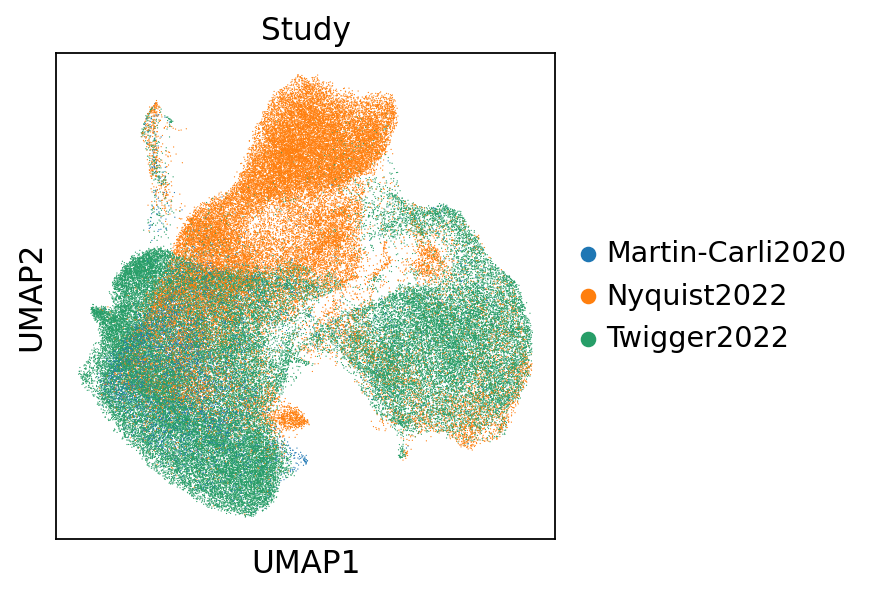

In [63]:
sc.pl.umap(adata, color=["Study"])

In [64]:
twigger_overlap_obsames = list(set(twigger.obs_names).intersection(set(adata.obs_names)))

adata.obs.loc[twigger_overlap_obsames,"Twigger Labels"] = twigger.obs.loc[twigger_overlap_obsames,"Epithelial.clusters"]

nyquist_overlap_obsames = list(set(nyquist.obs_names).intersection(set(adata.obs_names)))
adata.obs.loc[nyquist_overlap_obsames,"Nyquist Labels"] = nyquist.obs.loc[nyquist_overlap_obsames,"General_Celltype"]

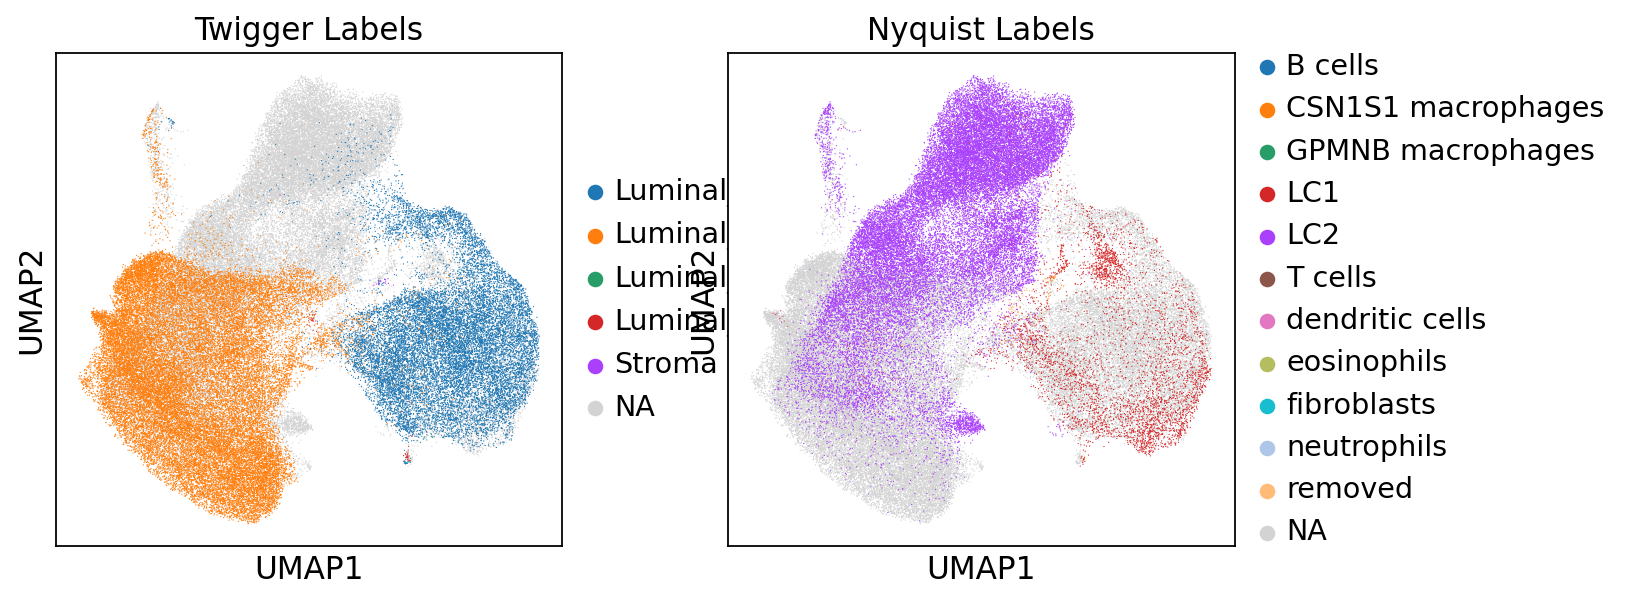

In [65]:
sc.pl.umap(adata, color=["Twigger Labels","Nyquist Labels"])

In [71]:
sc.tl.leiden(adata, resolution=0.3)

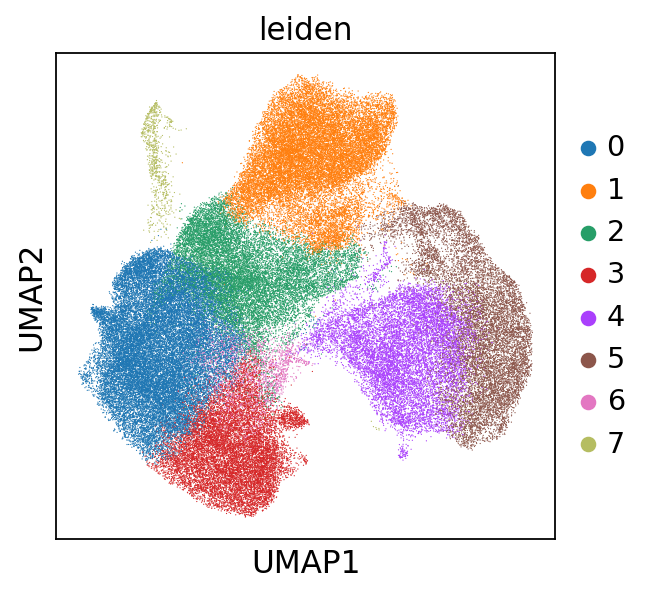

In [72]:
sc.pl.umap(adata,color="leiden")

In [73]:
clusters = {"0":"LC2","1":"LC2","2":"LC2","3":"LC2","4":"LC1","5":"LC1","6":"LC2","7":"Cycling"}

adata.obs["clusters"] = adata.obs["leiden"].map(clusters)

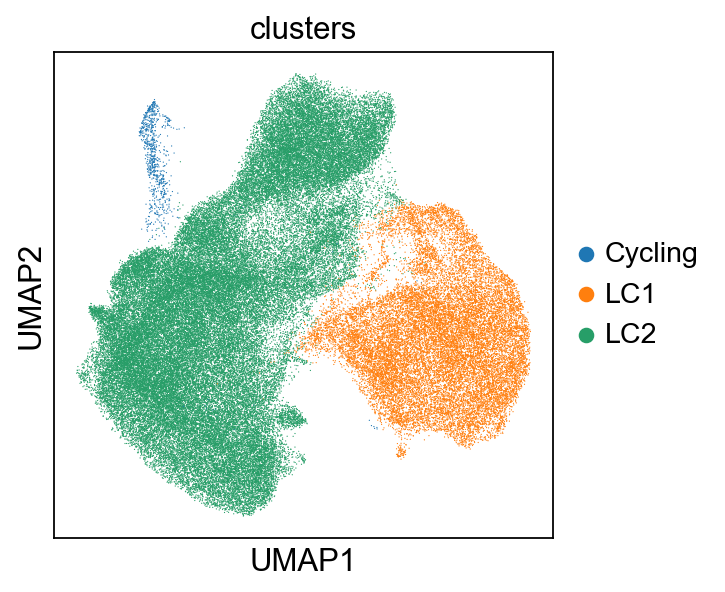

In [6]:
sc.pl.umap(adata,color="clusters")